In [1]:
import os
from glob import glob

import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
root_dir = './data/'
img_path = root_dir + 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/'
train_dir = img_path + 'train'
test_dir = img_path + 'test'

In [4]:
metadata = pd.read_csv(os.path.join(root_dir, 'Chest_xray_Corona_Metadata.csv'))
metadata.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [5]:
metadata.describe()

,Unnamed: 0
count,5910.000000
mean,2957.075635
std,1710.186149
min,0.000000
25%,1477.250000
50%,2954.500000
75%,4431.750000
max,5932.000000


In [6]:
# count null values
for c in metadata.columns:
    print('Number of empty/missing values on column {}: {}'.format(c, metadata[c].isnull().sum()))

Number of empty/missing values on column Unnamed: 0: 0
Number of empty/missing values on column X_ray_image_name: 0
Number of empty/missing values on column Label: 0
Number of empty/missing values on column Dataset_type: 0
Number of empty/missing values on column Label_2_Virus_category: 5841
Number of empty/missing values on column Label_1_Virus_category: 1576


In [7]:
# replace those empty values by a default value
metadata = metadata.fillna(value='unknown')
metadata.isnull().sum()

Unnamed: 0                0
X_ray_image_name          0
Label                     0
Dataset_type              0
Label_2_Virus_category    0
Label_1_Virus_category    0
dtype: int64

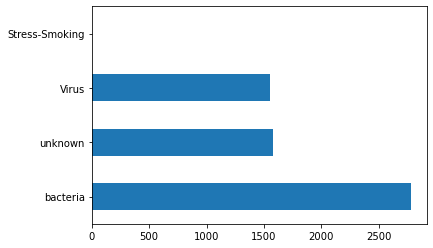

In [8]:
virus_category_1 = metadata['Label_1_Virus_category'].value_counts()
virus_category_1.plot(kind='barh')

plt.show()

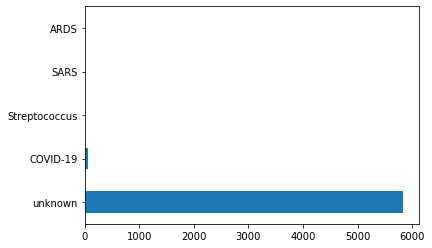

In [9]:
virus_category_2 = metadata['Label_2_Virus_category'].value_counts()
virus_category_2.plot(kind='barh')

plt.show()

<AxesSubplot:>

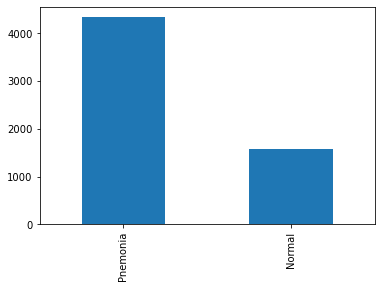

In [10]:
label = metadata['Label'].value_counts()
label.plot(kind='bar')

In [11]:
df_train = metadata[metadata['Dataset_type']=='TRAIN']
df_test = metadata[metadata['Dataset_type']=='TEST']

print('Training data:', df_train.shape)
print('Testing data:', df_test.shape)

Training data: (5286, 6)
Testing data: (624, 6)


In [21]:
df_train.loc[df_train['Label'].eq('Normal'), 'class'] = 'healthy'
df_train.loc[(df_train['class'].ne('healthy') & df_train['Label_1_Virus_category'].eq('bacteria')), 'class'] = 'bacteria';
df_train.loc[(df_train['class'].ne('healthy') & df_train['class'].ne('bacteria') & df_train['Label_2_Virus_category'].eq('COVID-19')), 'class'] = 'COVID-19';
df_train.loc[(df_train['class'].ne('healthy') & df_train['class'].ne('bacteria') & df_train['class'].ne('COVID-19')), 'class'] = 'other';

df_test.loc[df_test['Label'].eq('Normal'), 'class'] = 'healthy'
df_test.loc[(df_test['class'].ne('healthy') & df_test['Label_1_Virus_category'].eq('bacteria')), 'class'] = 'bacteria';
df_test.loc[(df_test['class'].ne('healthy') & df_test['class'].ne('bacteria') & df_test['Label_2_Virus_category'].eq('COVID-19')), 'class'] = 'COVID-19';
df_test.loc[(df_test['class'].ne('healthy') & df_test['class'].ne('bacteria') & df_test['class'].ne('COVID-19')), 'class'] = 'other';

print(df_train['class'].value_counts())
print(df_test['class'].value_counts())

bacteria    2535
other       1351
healthy     1342
COVID-19      58
Name: class, dtype: int64
bacteria    242
healthy     234
other       148
Name: class, dtype: int64


C:\Users\Archel\anaconda3\envs\machine-learning\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\Archel\anaconda3\envs\machine-learning\lib\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)


In [23]:
target_dict = {'healthy': 0, 'bacteria': 1, 'COVID-19': 2, 'other': 3}
df_train['target'] = df_train['class'].map(target_dict)
df_test['target'] = df_test['class'].map(target_dict)

df_test.head()

<ipython-input-23-f510ec5992e6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['target'] = df_train['class'].map(target_dict)
<ipython-input-23-f510ec5992e6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['target'] = df_test['class'].map(target_dict)


,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,class,target
5286,5309,IM-0021-0001.jpeg,Normal,TEST,unknown,unknown,healthy,0
5287,5310,IM-0019-0001.jpeg,Normal,TEST,unknown,unknown,healthy,0
5288,5311,IM-0017-0001.jpeg,Normal,TEST,unknown,unknown,healthy,0
5289,5312,IM-0016-0001.jpeg,Normal,TEST,unknown,unknown,healthy,0
5290,5313,IM-0015-0001.jpeg,Normal,TEST,unknown,unknown,healthy,0


In [74]:
def plot_img_hist(path, label, num_of_images):
    fig, ax = plt.subplots(num_of_images, 2, figsize=(15, 2.5*num_of_images))
    
    for i, file in enumerate(path):
        im = plt.imread(file)
        ax[i,0].imshow(im, cmap=plt.cm.bone)
        ax[i,1].hist(im.ravel(), 256, [0,256])
        ax[i,0].axis('off')
        
        if i == 0:
            ax[i,0].set_title('X-rays')
            ax[i,1].set_title('Histograms')
        
    fig.suptitle('Target: {}'.format(label), size=16)
    
    plt.show()
    
def display_img_hist(img_path, dset, split, label, num_of_images):
    path = dset[dset['class']==label]['X_ray_image_name'].values
    sample_path = path[:num_of_images]
    img_dir = img_path + split
#     print(img_dir)
    sample_path = list(map(lambda x: os.path.join(img_dir, x), sample_path))
#     print(sample_path)
    
    plot_img_hist(sample_path, label, num_of_images)

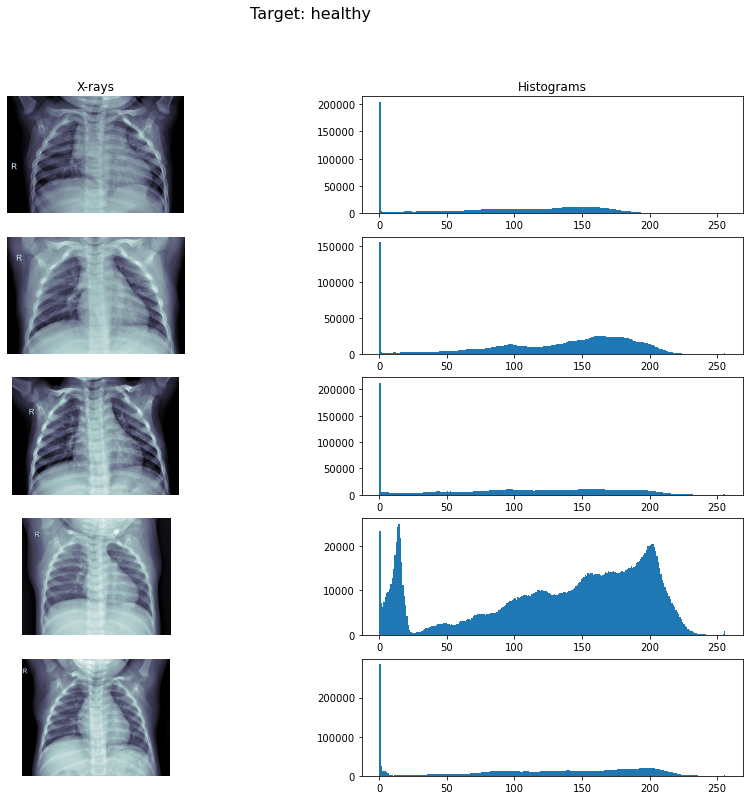

In [75]:
display_img_hist(img_path, df_train, 'train', 'healthy', 5)

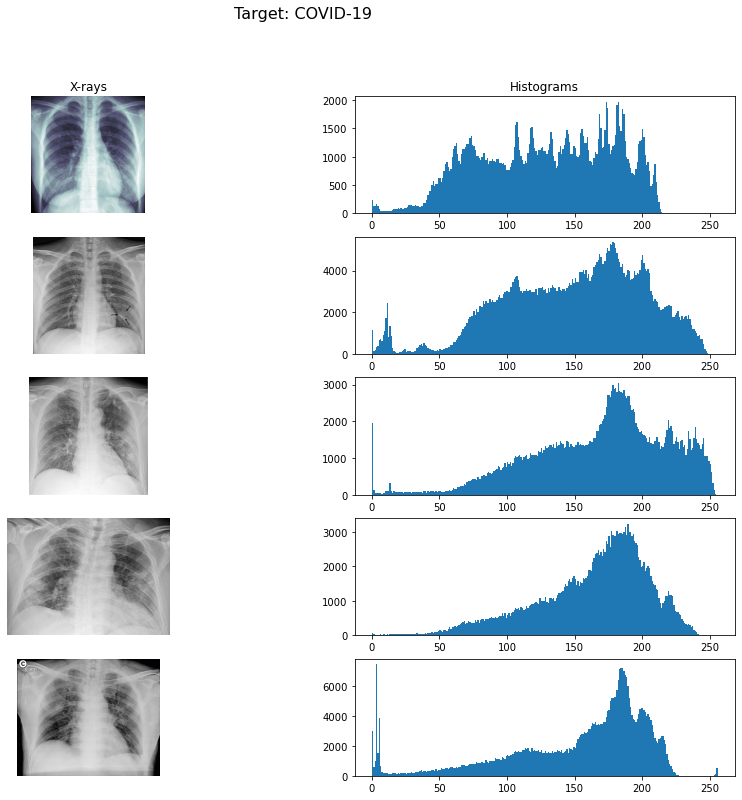

In [77]:
display_img_hist(img_path, df_train, 'train', 'COVID-19', 5)

In [24]:
class CoronaHackDataset(Dataset):
    
    def __init__(self, metadata, root_dir, transform=None):
        self.root_dir = root_dir
        self.metadata = metadata
        self.transform = transform
        self.list_dir = os.listdir(root_dir)
        
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        metadata = self.metadata.iloc[idx]
        fname = metadata['X_ray_image_name']
        
        try:
            file_idx = self.list_dir.index(fname)
        except:
            print('Image not found!')
            return None
        
        img_path = os.path.join(self.root_dir, self.list_dir[file_idx])
        img = Image.open(img_path).convert('RGB')
        img = img.resize((224,224))
        tensor_img = self.transform(img)
        tensor_lbl = torch.tensor(metadata['target'].item())
        
        return tensor_img, tensor_lbl

In [54]:
batch_size = 32
normalize = False
stats = ((0.0093, 0.0093, 0.0092),(0.4827, 0.4828, 0.4828))

if normalize:
    train_tfms = torchvision.transforms.ToTensor()
else:
    train_tfms = torchvision.transforms.Compose([torchvision.transforms.CenterCrop(224), torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(*stats, inplace=True)])
    
test_tfms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(*stats, inplace=True)])

In [55]:
train_ds, val_ds = train_test_split(df_train, test_size=0.1, random_state=1, shuffle=True)
train_ds, val_ds = train_ds.reset_index(drop=True), val_ds.reset_index(drop=True)

In [56]:
print('Total data:', len(metadata))
print('--After splitting--')
print('Train: {}'.format(len(train_ds)))
print('Validation: {}'.format(len(val_ds)))
print('Test: {}'.format(len(df_test)))

Total data: 5910
--After splitting--
Train: 4757
Validation: 529
Test: 624


In [57]:
train_dataset = CoronaHackDataset(train_ds, train_dir, transform=train_tfms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

valid_dataset = CoronaHackDataset(val_ds, train_dir, transform=test_tfms)
train_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

test_dataset = CoronaHackDataset(df_test, test_dir, transform=test_tfms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

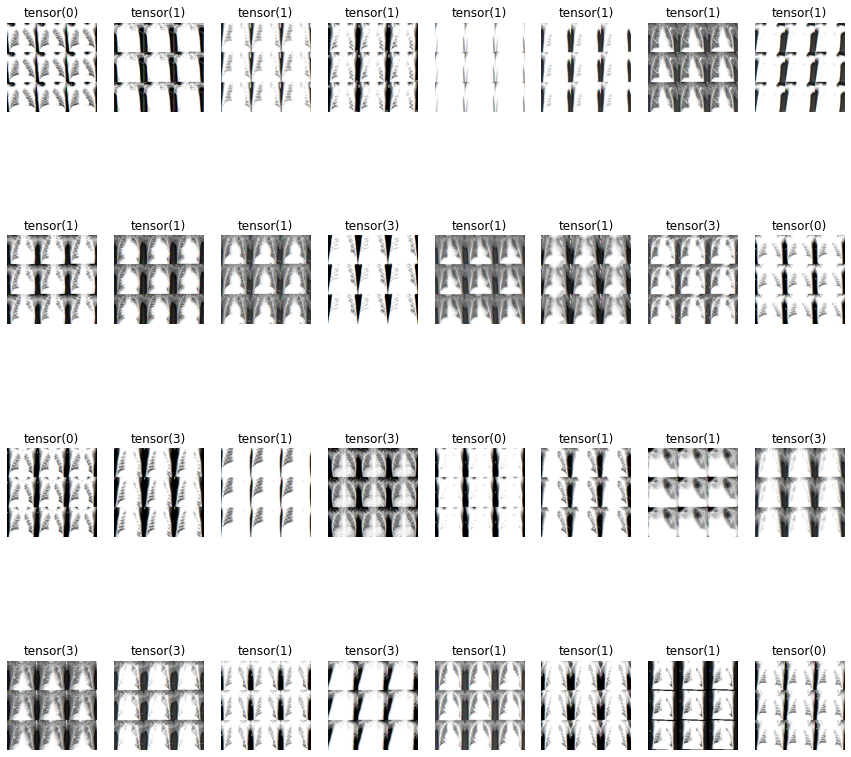

In [58]:
batch_x, batch_y = iter(train_loader).next()
fig, ax = plt.subplots(4, 8, figsize=(15,15))

for (x, y, axi) in zip(batch_x, batch_y, ax.flatten()):
    x = np.reshape(x, [224,224,3])
    axi.imshow(x)
    axi.set_title(y)
    
    axi.axis('off')

In [44]:
show_batch(train_loader)

NameError: name 'show_batch' is not defined